In [1]:
import os

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec as gridspec
import dill

import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u


ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
sparse_mice = stx.ymaze_sess_deets.sparse_mice

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
sparse_sessions = stx.ymaze_sess_deets.SparseKO_sessions
from STX3KO_analyses.path_dicts.path_dict_esay import path_dictionary as path_dict
pkl_base_dir = path_dict['pkl_root']


In [3]:
sparse_sessions.keys()

dict_keys(['SparseKO_05', 'SparseKO_02', 'SparseKO_03', 'SparseKO_06', 'SparseKO_08', 'SparseKO_09', 'SparseKO_10', 'SparseKO_11', 'SparseKO_13'])

In [4]:
mouse = 'SparseKO_13'
d = sparse_sessions[mouse][1]
print(d)

{'date': '25_05_2025', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 8, 'novel_arm': 1, 'exp_day': 2}


In [5]:
date, scene, session, scan = d['date'], d['scene'], d['session'], d['scan']
print(scene)
# basedir = f'/mnt/BigDisk/2P_scratch/{mouse}/{date}/{scene}'
# basedir = f'C://Users/esay/data/Stx3/{mouse}/{date}/{scene}'
# basedir = f'Z://giocomo/esay/Stx3/2pData/{mouse}/{date}/{scene}'
basedir = f'Z://giocomo/InVivoDA/2P_Data/{mouse}/{date}/{scene}'

stem =  os.path.join(basedir, f'{scene}_{session:03}_{scan:03}')

d.update({'mouse': mouse ,
          'scan_file':stem + '.sbx',
          'scanheader_file': stem + '.mat',
          'vr_filename': os.path.join("Z://giocomo/esay/Stx3/VRData",mouse,date,"%s_%d.sqlite" %(scene,session)),
          'scan_number': scan,
          'prompt_for_keys': False,
          'VR_only': False,
          'scanner': "NLW",
          'n_channels':2,
             })

YMaze_LNovel


In [6]:
sess = stx.session.YMazeSession(**d)
sess.load_scan_info(sbx_version=3)
sess.align_VR_to_2P(mux=True)
sess.load_suite2p_data_ES(which_ts=('F', 'Fneu'), mux = True)
# sess.load_suite2p_data(which_ts=('F', 'Fneu'))
sess.get_trial_info()



Fixing teleports
frame rate 31.25
(112792,) ttl times,(45569,) ca2+ frame times
last time: VR 1458.2511875, ca2+ 1458.176
frame rate 31.25
(112792,) ttl times,(45569,) ca2+ frame times
last time: VR 1458.2511875, ca2+ 1458.176
(22785, 17) (22784, 17)
['Z://giocomo/InVivoDA/2P_Data/SparseKO_13/25_05_2025/YMaze_LNovel\\YMaze_LNovel_002_008\\suite2p', 'Z://giocomo/InVivoDA/2P_Data/SparseKO_13/25_05_2025/YMaze_LNovel\\YMaze_LNovel_002_008\\chan2/suite2p']
1
2
3
4
5


In [7]:
sess.vr_data.shape[0]

76177

In [34]:
# modify timeseries for MUXED data (add Nan frames between values to align with lick/speed)

def align_mux(sess):
    for key in list (sess.timeseries.keys()):
        data=sess.timeseries[key]

        if f'channel_0' in key:
            new_data = np.empty((data.shape[0], data.shape[1] *2))
            new_data[:] = np.nan
            new_data[:,::2] = data # place chan0 values at even index

        elif f'channel_1' in key:
            new_data = np.empty((data.shape[0], data.shape[1] *2))
            new_data[:] = np.nan
            new_data[:,1::2] = data # place chan1 values at odd index

        else:
            continue 

        sess.timeseries[key] = new_data
    chan0_nanmask = np.arange(sess.timeseries['channel_0_F'].shape[1]) % 2 ==0
    chan1_nanmask = np.arange(sess.timeseries['channel_1_F'].shape[1]) % 2 ==1
    return sess, chan0_nanmask, chan1_nanmask

def reverse_mux_alignment(self, df_key = "channel_0_F_dff"):
    df = self.timeseries[df_key]

    unmux = df[:, ~np.isnan(df).all(axis=0)]

    self.timeseries[df_key] = unmux


In [8]:
# add nan values in even and odd spaces for matching lengths
sess, chan0_nanmask, chan1_nanmask = align_mux(sess)
# chan0_nanmask, chan1_nanmask = get_nanmask(sess)

In [48]:
# mask nan values
chan0_nanmask = np.arange(sess.timeseries['channel_0_F'].shape[1]) % 2 ==0
chan1_nanmask = np.arange(sess.timeseries['channel_1_F'].shape[1]) % 2 ==1
chan0_nanmask, chan1_nanmask

(array([ True, False,  True, ..., False,  True, False]),
 array([False,  True, False, ...,  True, False,  True]))

In [26]:
def trim_vr(sess):
    print(sess.vr_data.shape[0] - sess.timeseries['channel_0_F'].shape[1])
    if (sess.vr_data.shape[0] - sess.timeseries['channel_0_F'].shape[1]) ==1:
        print('Odd number of VR frames, trimming')
        sess.vr_data.drop(sess.vr_data.tail(1).index,inplace=True) # drop last n rows
    sess.vr_data.shape

In [10]:
sess.neuropil_corrected_dff_ES(Fkey = 'channel_0_F', 
                            Fneukey='channel_0_Fneu', 
                            tau=sess.s2p_ops['channel_0']['tau'],
                               chan_mask = chan0_nanmask,
                            spks_key='channel_0_spks')
sess.neuropil_corrected_dff_ES(Fkey = 'channel_1_F', 
                            Fneukey='channel_1_Fneu', 
                            tau=sess.s2p_ops['channel_1']['tau'],
                               chan_mask = chan1_nanmask,
                            spks_key='channel_1_spks')


365 6031
[ 366  368  370 ... 6026 6028 6030]
7900 13008
[ 7900  7902  7904 ... 13002 13004 13006]
14876 19562
[14876 14878 14880 ... 19556 19558 19560]
21434 26405
[21434 21436 21438 ... 26400 26402 26404]
28277 33884
[28278 28280 28282 ... 33878 33880 33882]
35756 45568
[35756 35758 35760 ... 45562 45564 45566]


c:\users\esay\repos\twoputils\TwoPUtils\spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


365 6031
[ 365  367  369 ... 6025 6027 6029]
7900 13008
[ 7901  7903  7905 ... 13003 13005 13007]
14876 19562
[14877 14879 14881 ... 19557 19559 19561]
21434 26405
[21435 21437 21439 ... 26399 26401 26403]
28277 33884
[28277 28279 28281 ... 33879 33881 33883]
35756 45568
[35757 35759 35761 ... 45563 45565 45567]


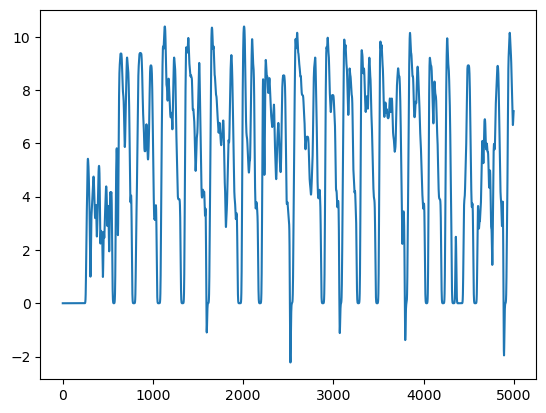

In [11]:
sess.add_timeseries(licks=sess.vr_data['lick']._values)
sess.add_pos_binned_trial_matrix('licks')
speed = sess.vr_data['dz']._values*sess.scan_info['frame_rate']
sess.add_timeseries(speed=sess.vr_data['dz']._values)
sess.add_pos_binned_trial_matrix('speed')

fig,ax = plt.subplots()
ax.plot(speed[:5000])


spks = np.copy(sess.timeseries['channel_0_F_dff'])
sess.add_timeseries(channel_0_F_dff_speed_filt=spks)
spks[:,speed<2]=np.nan
sess.add_pos_binned_trial_matrix('channel_0_F_dff_speed_filt')


spks = np.copy(sess.timeseries['channel_1_F_dff'])
spks[:,speed<2]=np.nan
sess.add_timeseries(channel_1_F_dff_speed_filt=spks)
sess.add_pos_binned_trial_matrix('channel_1_F_dff_speed_filt')

sess.add_timeseries(channel_0_spks_norm = sess.timeseries['channel_0_spks']/np.nanpercentile(sess.timeseries['channel_0_spks'],99,axis=1,keepdims=True))
sess.add_pos_binned_trial_matrix('channel_0_spks_norm')
sess.add_timeseries(channel_1_spks_norm = sess.timeseries['channel_1_spks']/np.nanpercentile(sess.timeseries['channel_1_spks'],99,axis=1,keepdims=True))
sess.add_pos_binned_trial_matrix('channel_1_spks_norm')

In [12]:
sess.place_cells_calc(Fkey='channel_0_F_dff', out_key='channel_0_F_dff', nperms=100)
sess.place_cells_calc(Fkey='channel_1_F_dff', out_key='channel_1_F_dff', nperms=100)

perm 0
perm 0
perm 0
perm 0


In [16]:
# create mask for place cells only 
def make_mask(sess): 
    chan0_mask_pf_left = sess.place_cell_info['channel_0_F_dff']['left']['masks']
    chan0_mask_pf_right = sess.place_cell_info['channel_0_F_dff']['right']['masks']
    chan1_mask_pf_left = sess.place_cell_info['channel_1_F_dff']['left']['masks']
    chan1_mask_pf_right = sess.place_cell_info['channel_1_F_dff']['right']['masks']
    
    chan1_mask = chan1_mask_pf_left | chan1_mask_pf_right
    chan0_mask = chan0_mask_pf_left | chan0_mask_pf_right

    # mask for interneurons
    int_mask1 = u.is_putative_interneuron(sess, ts_key='channel_1_F_dff', method='speed',
                                prct=10, r_thresh=0.3)
    
    int_mask0 = u.is_putative_interneuron(sess, ts_key='channel_0_F_dff', method='speed',
                                prct=10, r_thresh=0.3)
    
    chan1_mask = np.logical_and(chan1_mask, int_mask1)
    chan0_mask = np.logical_and(chan0_mask, int_mask0)

    chan1_left_mask = np.logical_and(chan1_mask_pf_left, int_mask1)
    chan1_right_mask = np.logical_and(chan1_mask_pf_right, int_mask1)
    chan0_left_mask = np.logical_and(chan0_mask_pf_left, int_mask0)
    chan0_right_mask = np.logical_and(chan0_mask_pf_right, int_mask0)
    
    sess.place_cell_info['channel_0_F_dff']['left']['masks'] = chan0_left_mask
    sess.place_cell_info['channel_0_F_dff']['right']['masks'] = chan0_right_mask
    sess.place_cell_info['channel_1_F_dff']['left']['masks'] = chan1_left_mask
    sess.place_cell_info['channel_1_F_dff']['right']['masks'] = chan1_right_mask

In [17]:
make_mask(sess)

In [18]:
# add nan values back into trials
reverse_mux_alignment(sess, df_key = 'channel_0_F_dff')
reverse_mux_alignment(sess, df_key = 'channel_1_F_dff')

In [19]:
output_path = os.path.join("C://Users/esay/data/Stx3/YMazeSessPkls/")
tpu.sess.save_session(sess,output_path)

In [37]:
def plot_cells(trial_mat, cell_inds=None, n_cols=20):
    '''

    :param ca1:
    :param cell_inds: indices of cells to plot
    :param save_figs:
    :return:
    '''

    if cell_inds is None:
        cell_inds = np.arange(trial_mat.shape[-1])

    n_rows = int(np.ceil(cell_inds.shape[0] / n_cols))
    fig = plt.figure(figsize=[30, 3 * n_rows])
    gs = gridspec(n_rows, n_cols)
    '''
    ES changes: 
    - indexing for pc only indexing error
    '''
    
    # for cell in cell_inds:
    for i, cell in enumerate(cell_inds):
        # col = cell % n_cols
        col = i % n_cols
        # row = int(cell / n_cols)
        row = i //n_cols
        ax = fig.add_subplot(gs[row, col])
        h = ax.imshow(trial_mat[:, :, cell], cmap="magma",aspect = 'auto',interpolation='none')

        if col == 0:
            ax.set_xlabel('pos')
            ax.set_ylabel('trial #')
            if row==0:
                plt.colorbar(h,ax=ax)
        else:
            ax.set_xticks([])
            ax.set_yticks([])
    fig.subplots_adjust(hspace=.3)
    return fig

In [38]:
# load 
mouse = 'SparseKO_06'
d = sparse_sessions[mouse][0]
date = d['date']
scene = d['scene']
session = d['session']
pkldir = os.path.join('C://Users/esay/data/Stx3/YMazeSessPkls/', mouse,  date, f'{scene}_{session}.pkl')
sess = stx.session.YMazeSession.from_file(pkldir, verbose=False)

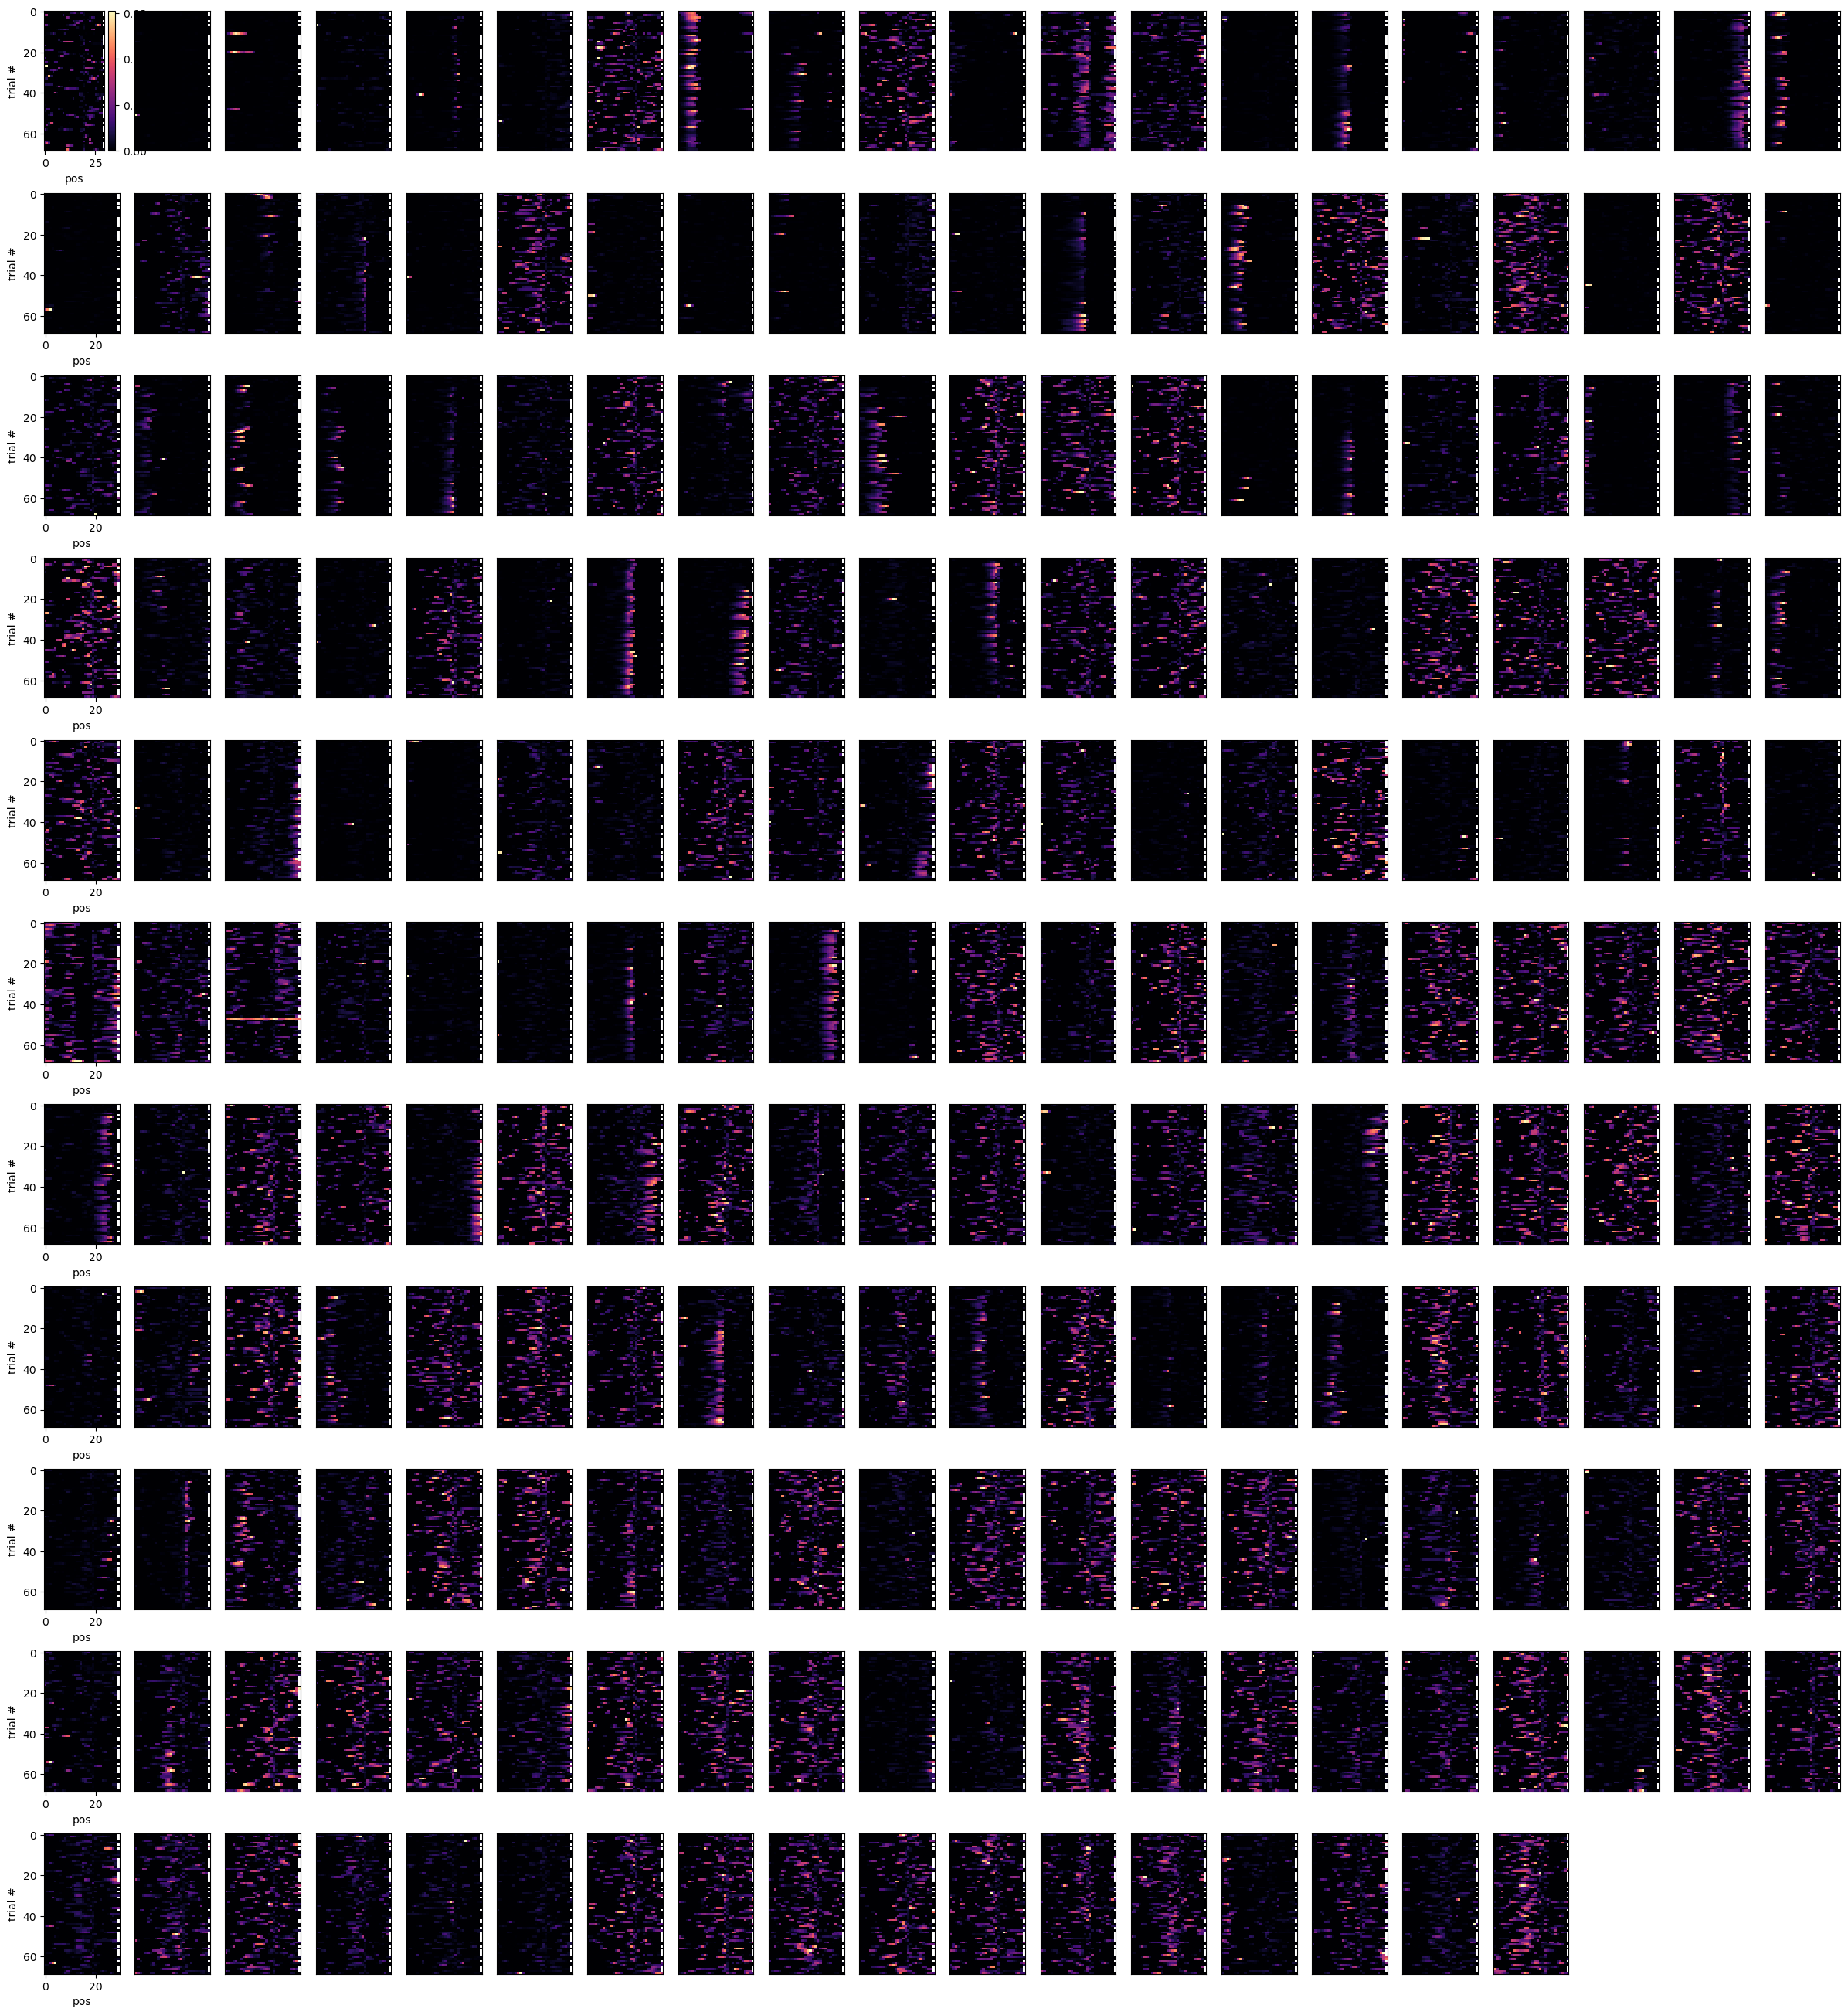

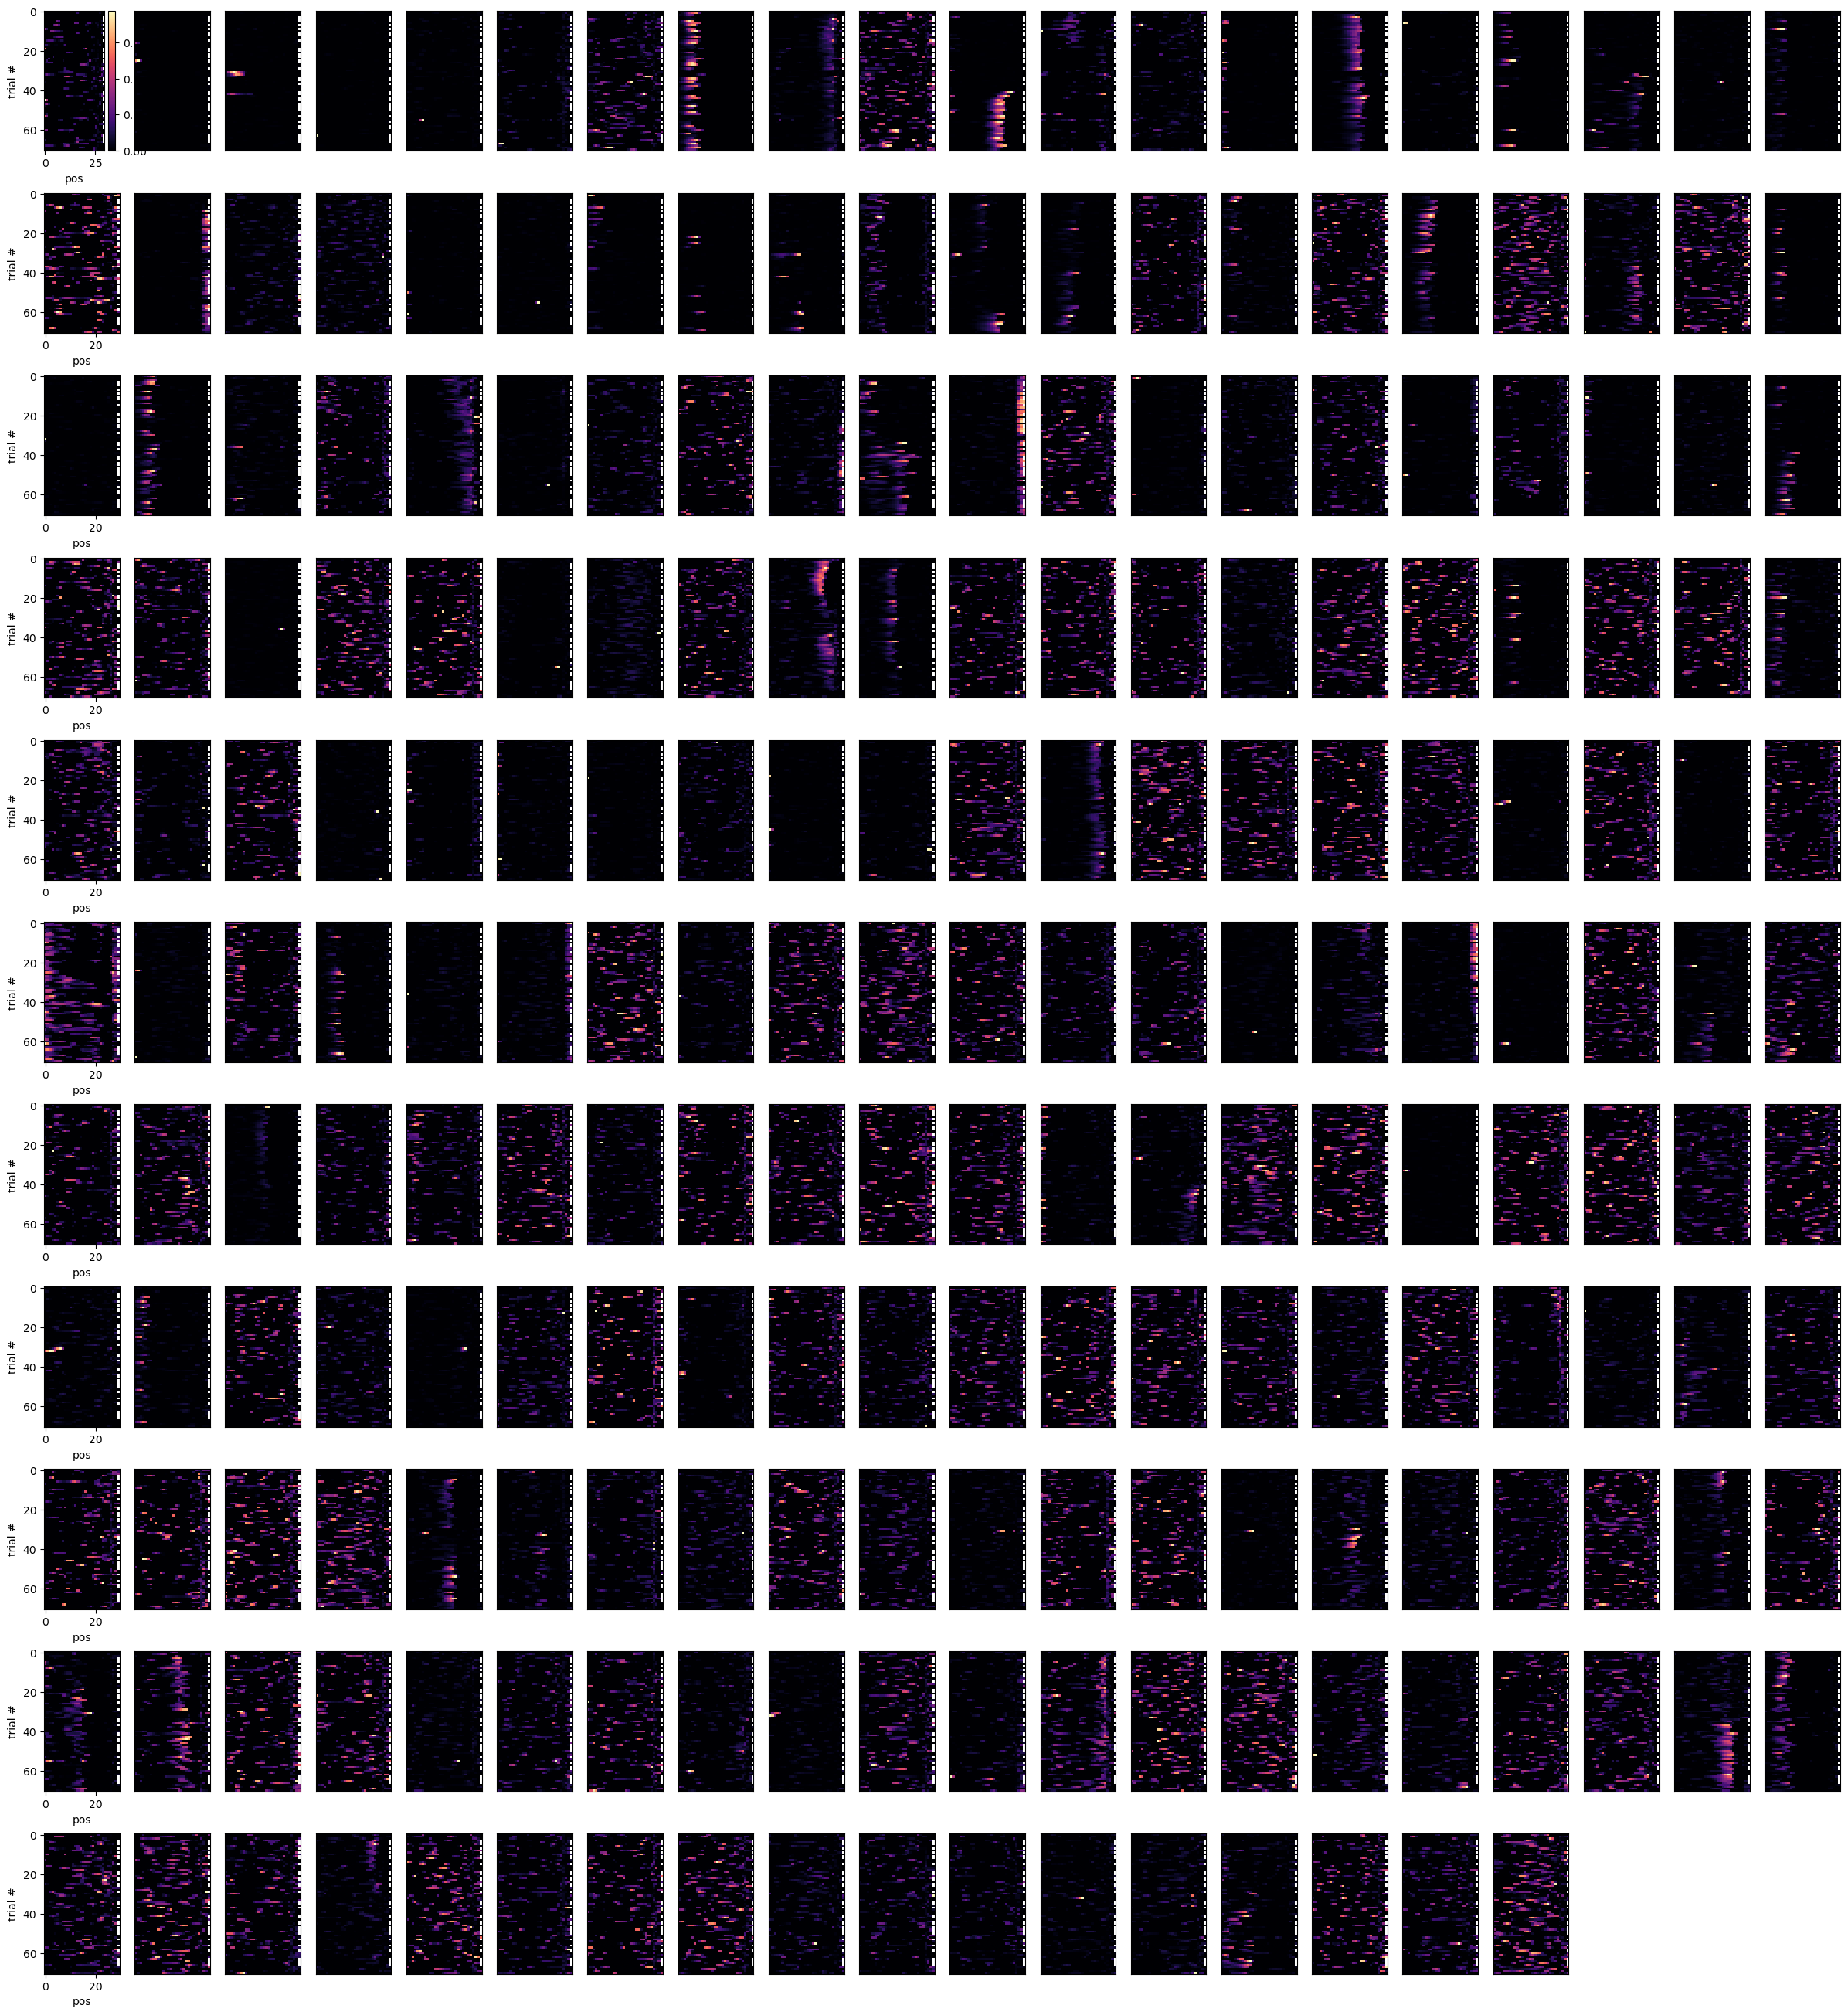

In [381]:
# left trials, channel 0
trial_mask = (sess.trial_info['LR']==-1)

tmat = sess.trial_matrices['channel_0_spks']
n_cells = tmat.shape[-1]
fig = plot_cells(tmat[trial_mask,:,:], cell_inds=np.array([r for r in range(n_cells)]))

# right trials, channel 0
trial_mask = (sess.trial_info['LR']==1)
fig = plot_cells(tmat[trial_mask,:,:], cell_inds=np.array([r for r in range(n_cells)]))

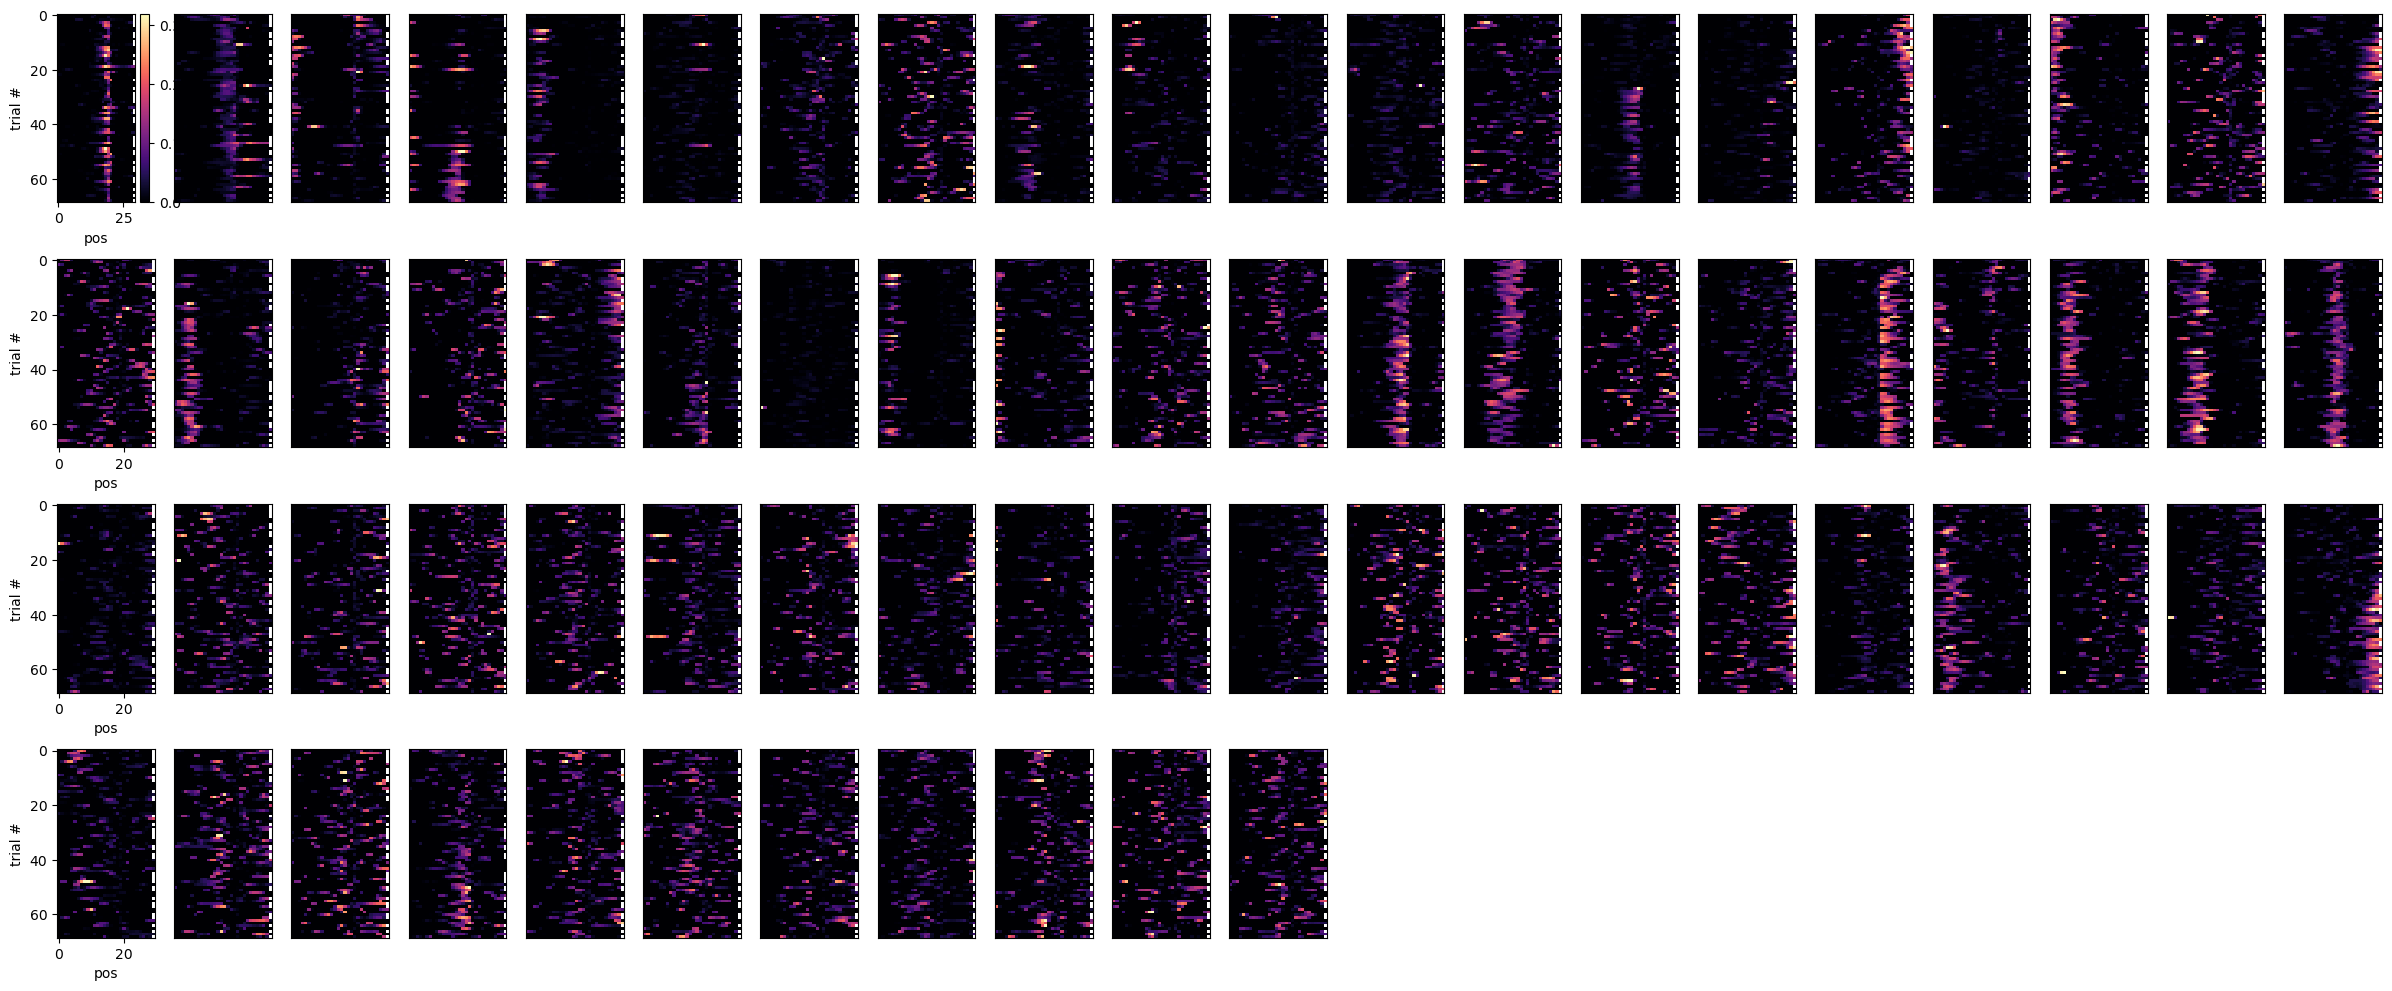

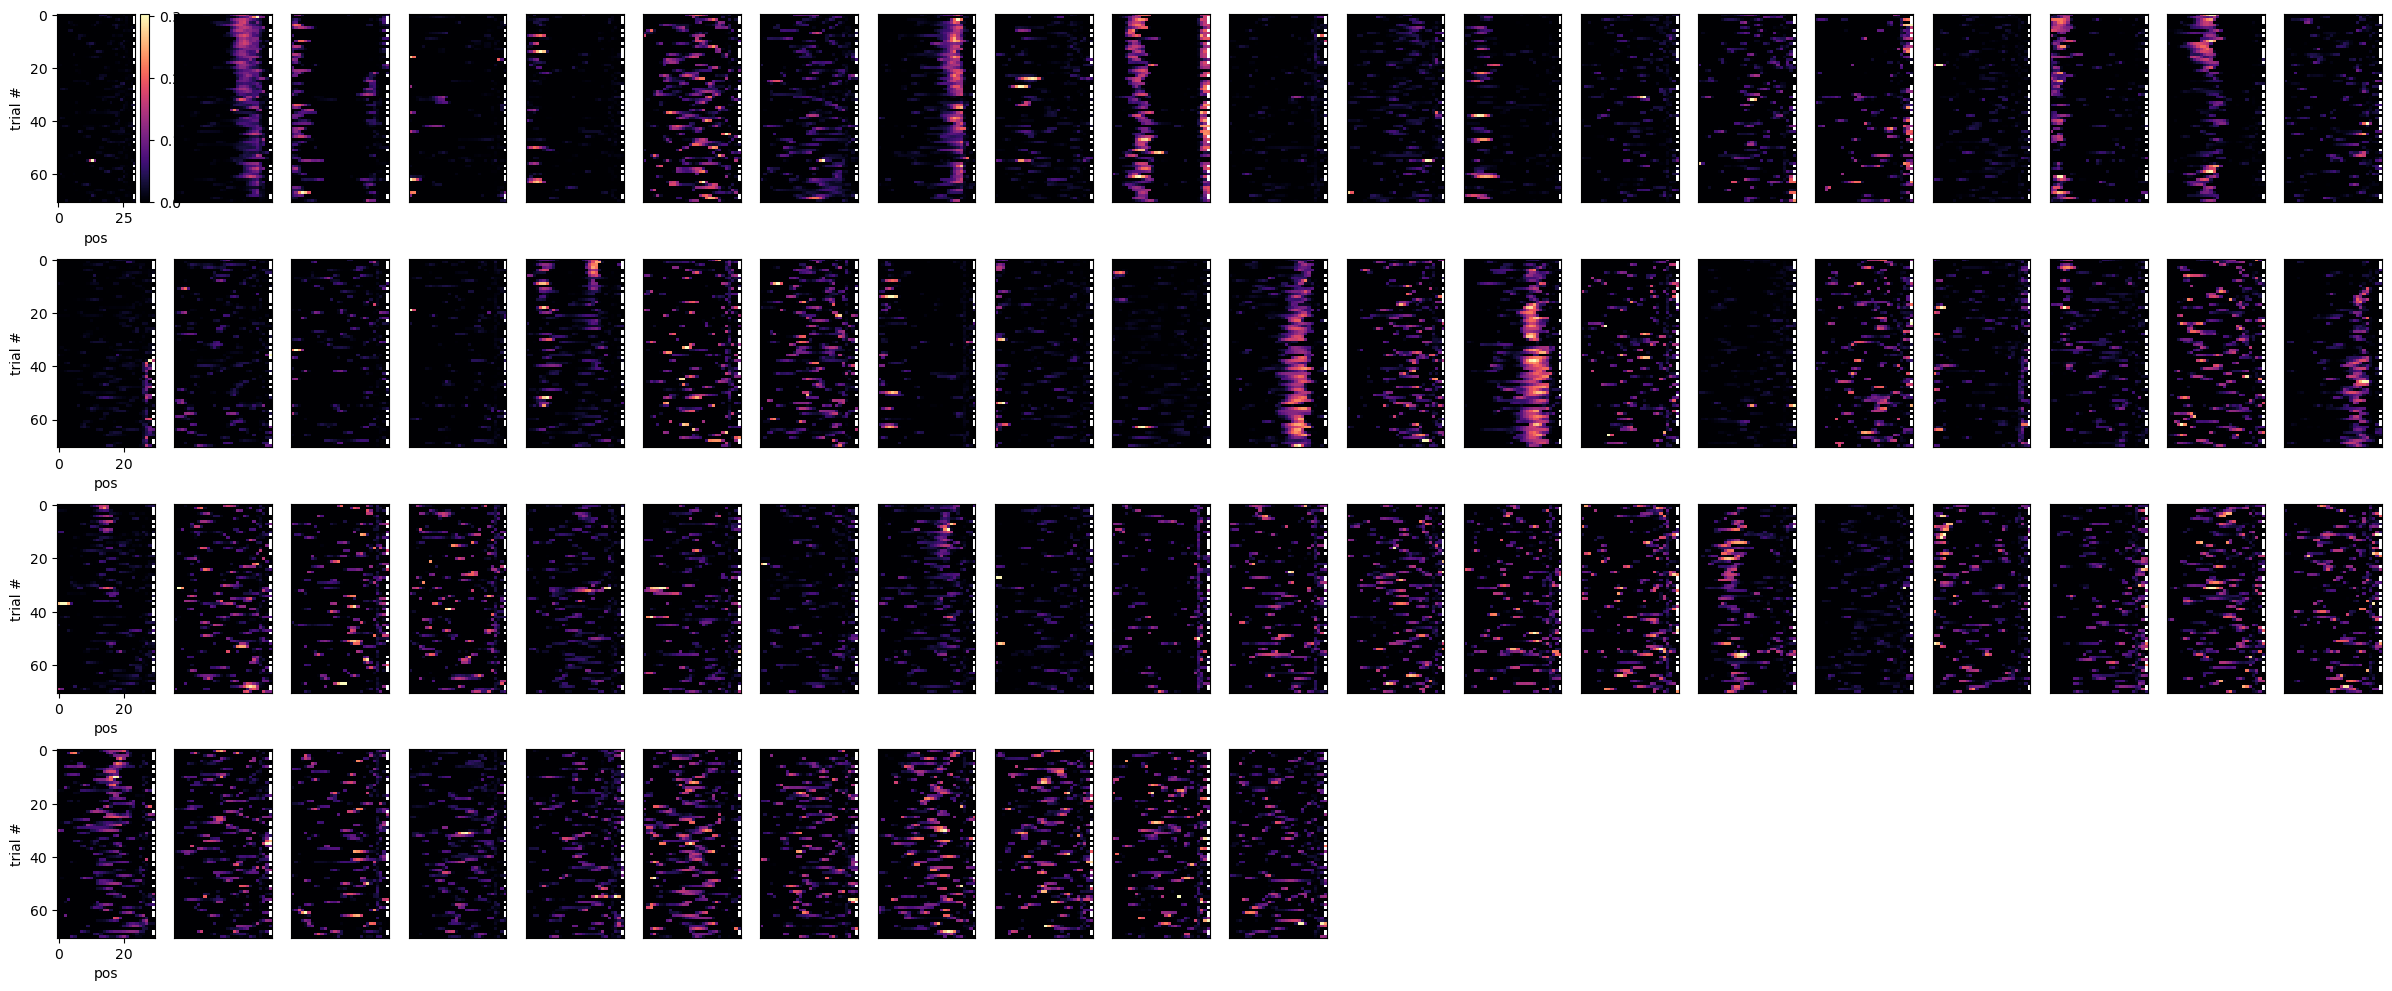

In [382]:
# left trials, channel 1
trial_mask = (sess.trial_info['LR']==-1)

tmat = sess.trial_matrices['channel_1_spks']
n_cells = tmat.shape[-1]
fig = plot_cells(tmat[trial_mask,:,:], cell_inds=np.array([r for r in range(n_cells)]))

# right trials, channel 0
trial_mask = (sess.trial_info['LR']==1)
fig = plot_cells(tmat[trial_mask,:,:], cell_inds=np.array([r for r in range(n_cells)]))

In [39]:
def get_mask(sess):
    chan0_left_mask = sess.place_cell_info['channel_0_F_dff']['left']['masks'] 
    chan0_right_mask = sess.place_cell_info['channel_0_F_dff']['right']['masks'] 
    chan1_left_mask = sess.place_cell_info['channel_1_F_dff']['left']['masks'] 
    chan1_right_mask=sess.place_cell_info['channel_1_F_dff']['right']['masks'] 

    return chan0_left_mask, chan0_right_mask, chan1_left_mask, chan1_right_mask

chan0_left, chan0_right, chan1_left, chan1_right = get_mask(sess)

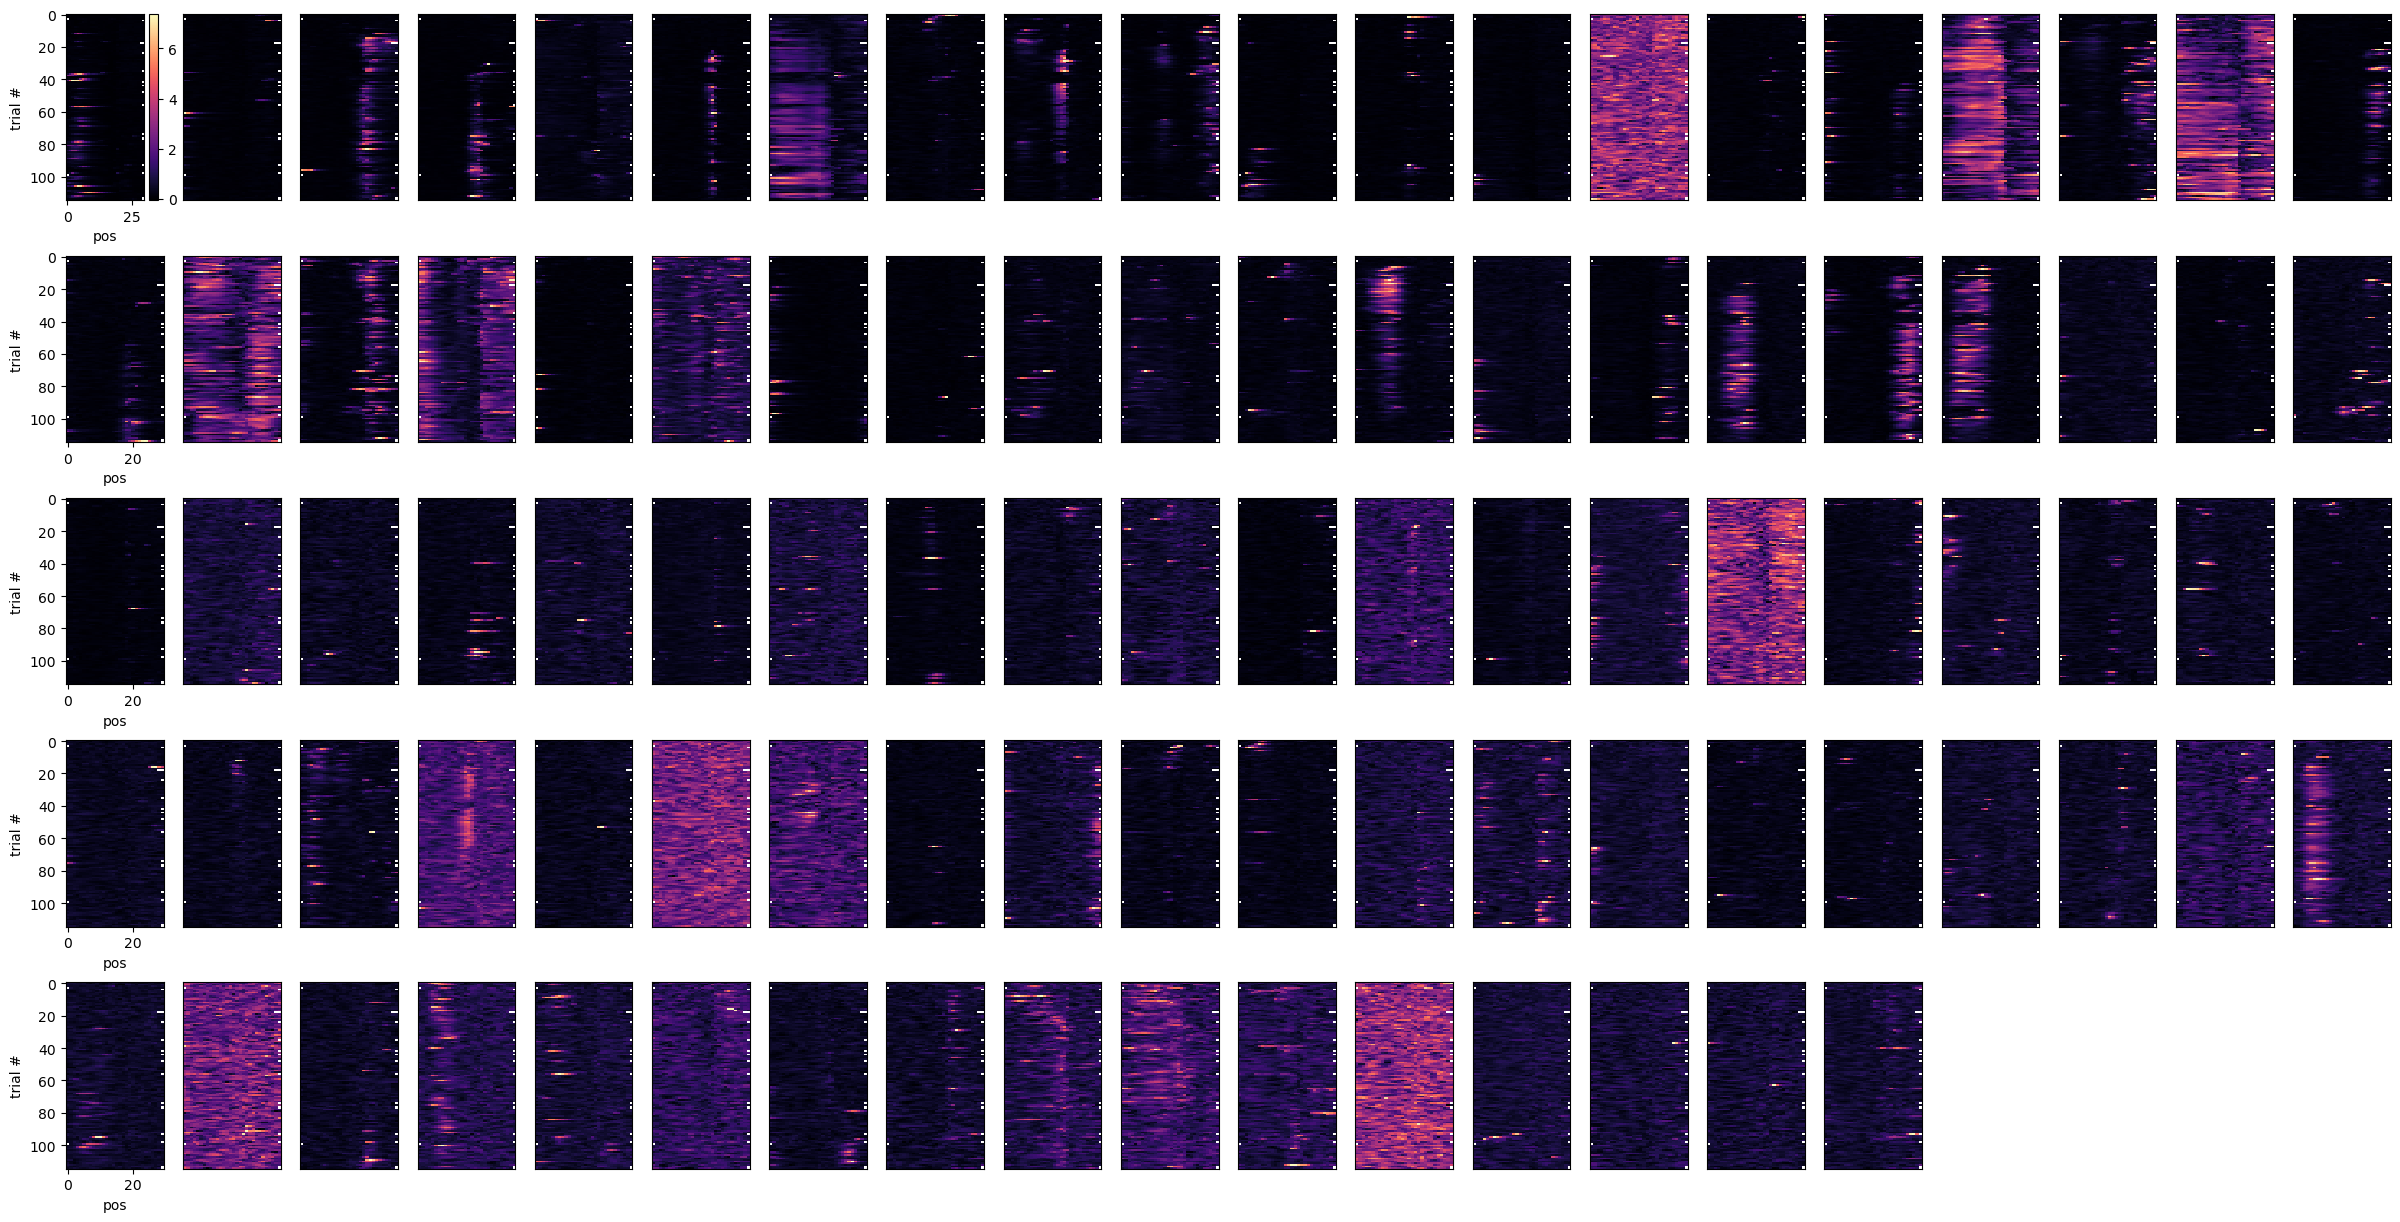

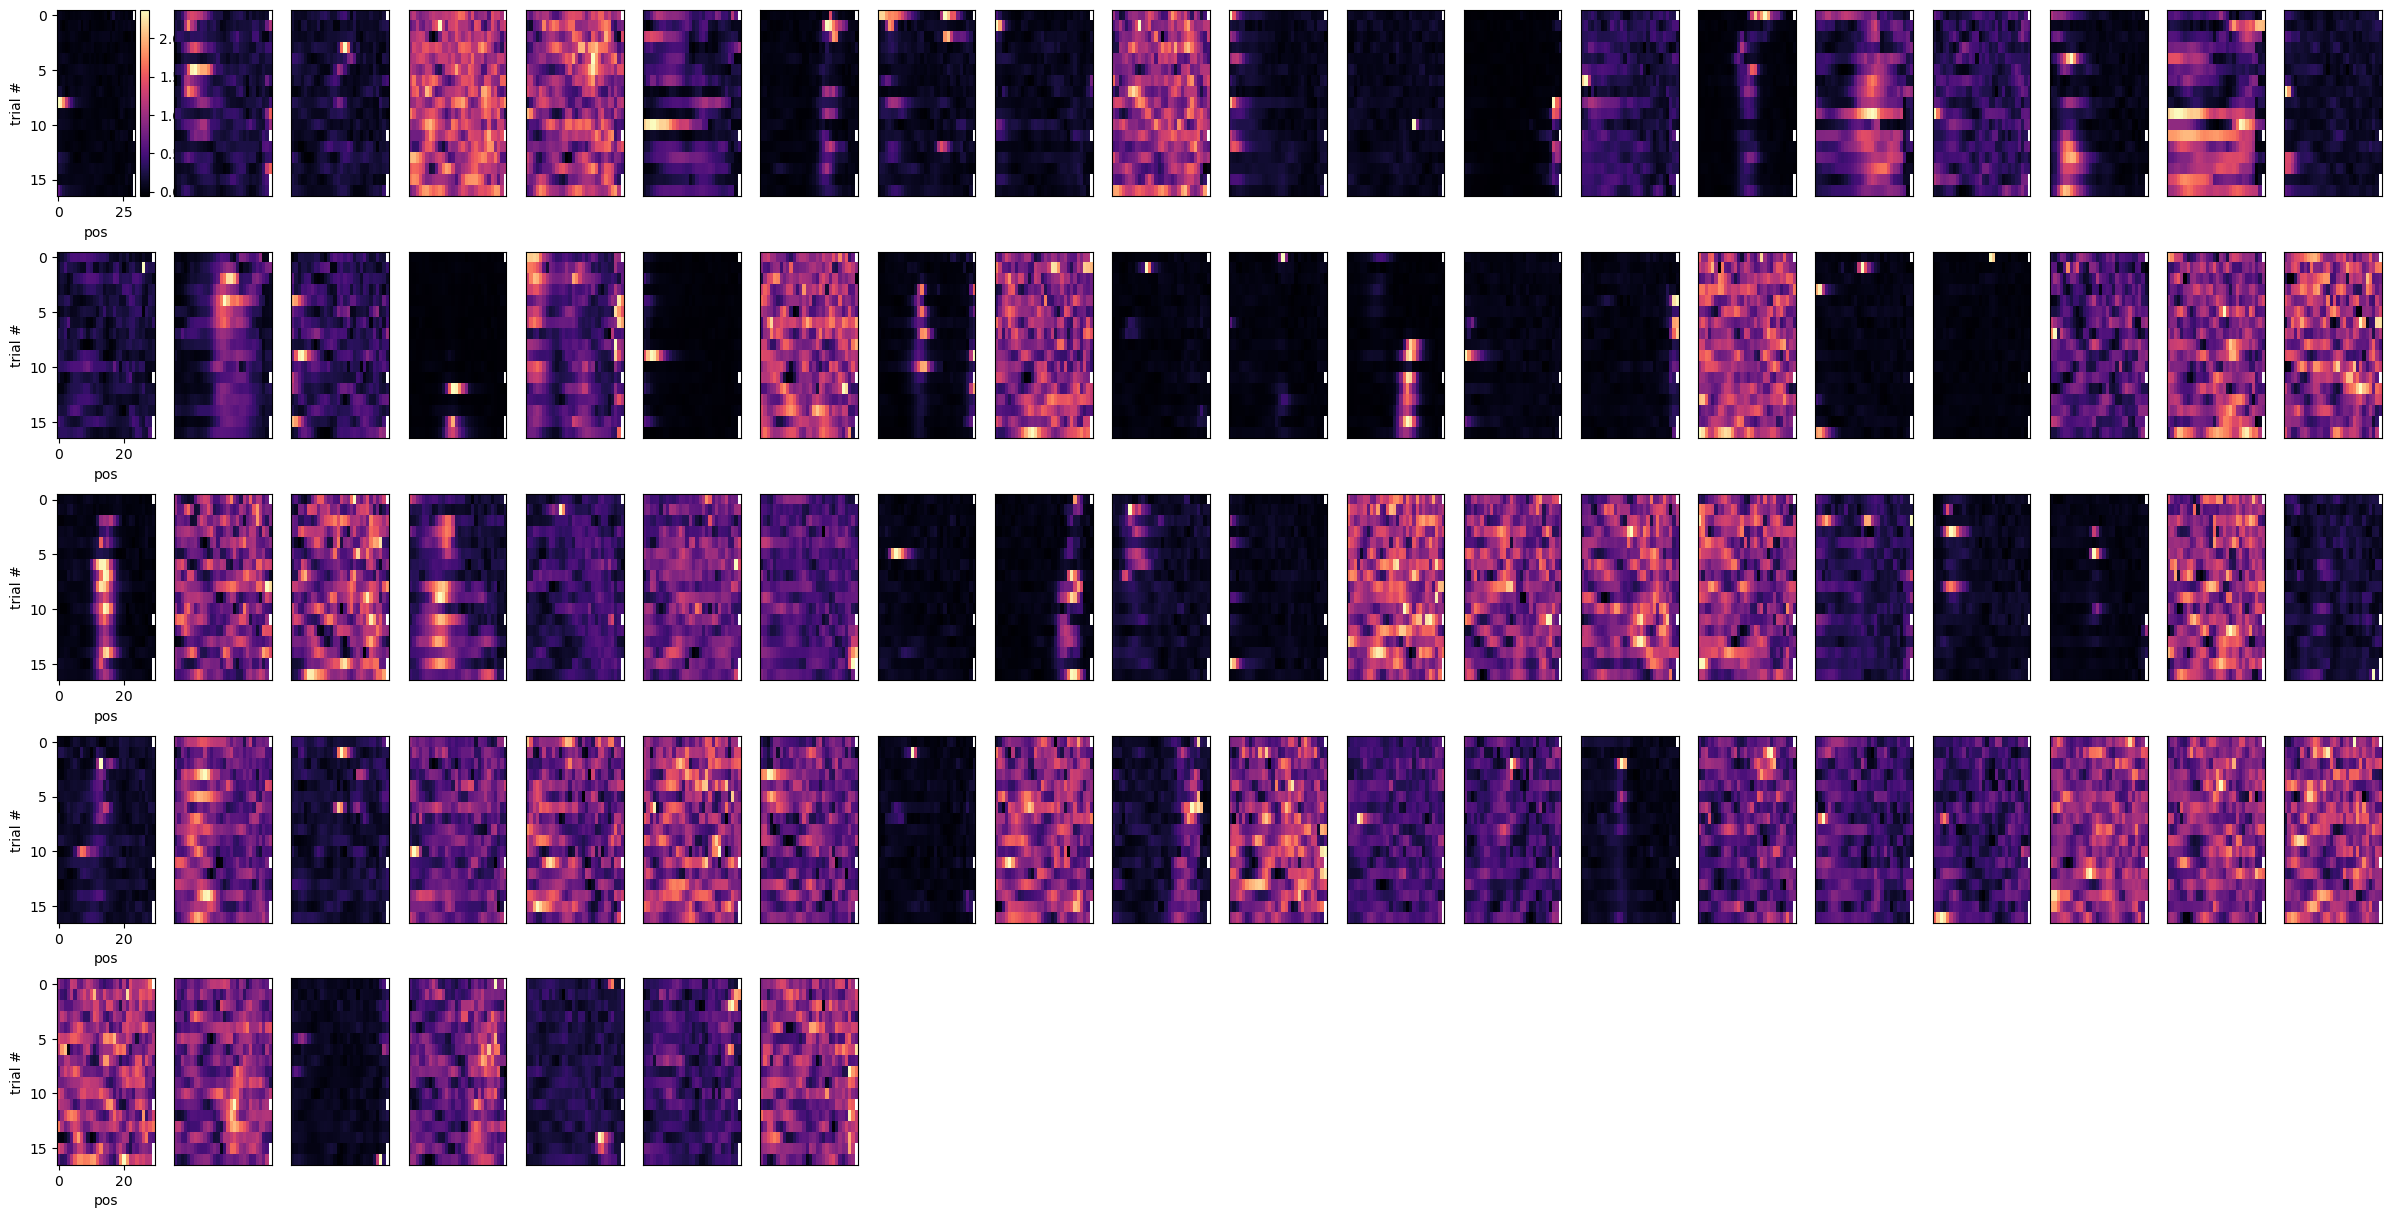

In [41]:
tmat = sess.trial_matrices['channel_0_F_dff_speed_filt']
n_cells = tmat.shape[-1]

# plot only place cells using place cell mask
pc_idx = np.where(chan0_left_mask[:n_cells])[0]
fig = plot_cells(tmat[sess.trial_info['LR']==-1*sess.novel_arm,:,:], cell_inds=pc_idx)

pc_idx = np.where(chan0_right_mask[:n_cells])[0]
fig = plot_cells(tmat[sess.trial_info['LR']==1*sess.novel_arm,:,:], cell_inds=pc_idx)


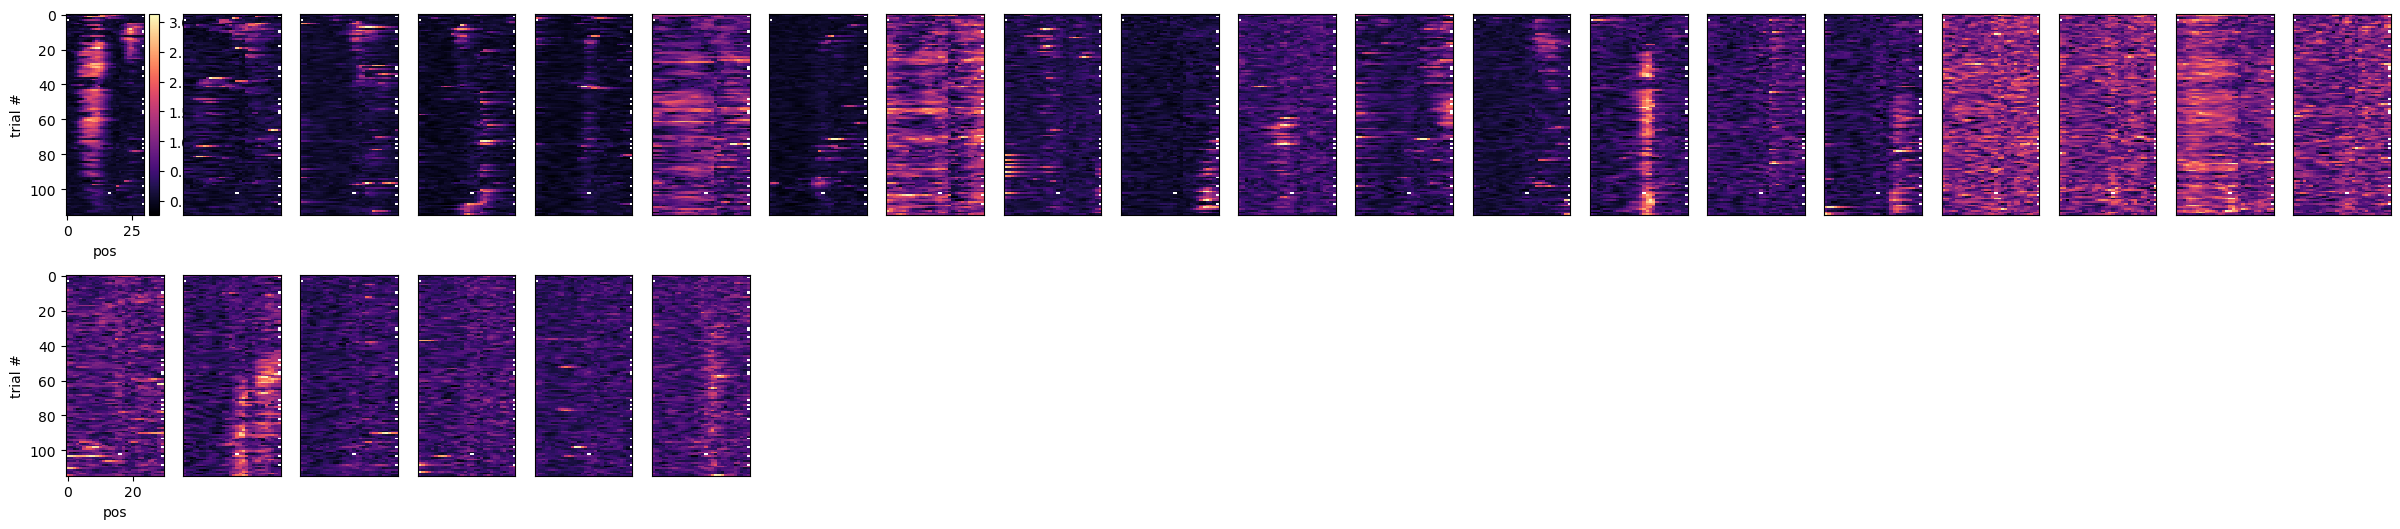

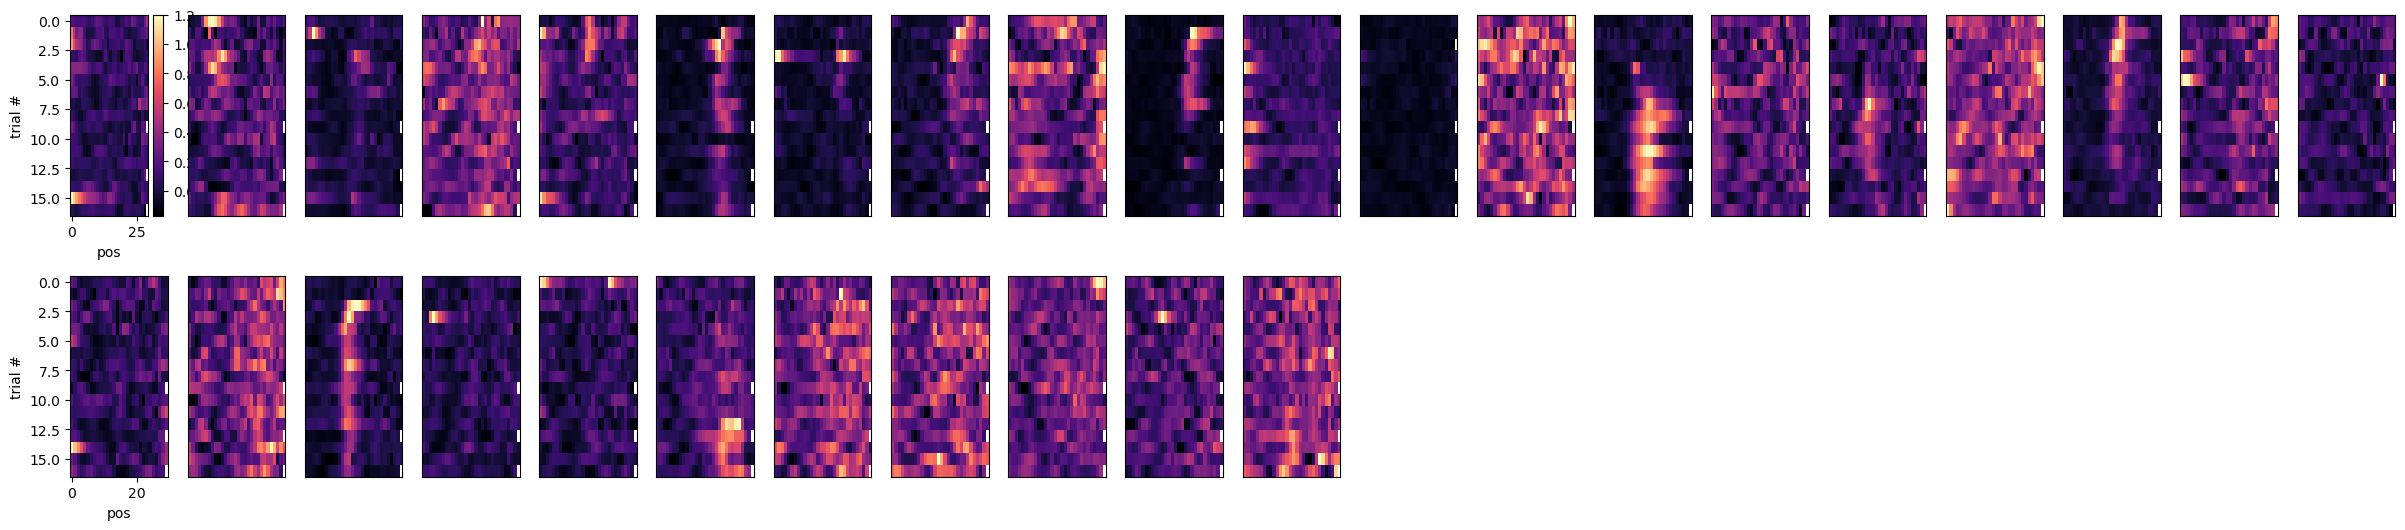

In [42]:
tmat = sess.trial_matrices['channel_1_F_dff_speed_filt']
n_cells = tmat.shape[-1]


#place cells only
pc_idx = np.where(chan1_right_mask[:n_cells])[0]
# fig = plot_cells(tmat, cell_inds=pc_idx)


fig = plot_cells(tmat[sess.trial_info['LR']==-1*sess.novel_arm,:,:], cell_inds=pc_idx)

pc_idx = np.where(chan1_left_mask[:n_cells])[0]
fig = plot_cells(tmat[sess.trial_info['LR']==1*sess.novel_arm,:,:], cell_inds=pc_idx)

In [25]:
def update_sess_dict(mouse, f, KO = True):
    scan_str = "%s_%03d_%03d" % (f['scene'],f['session'],f['scan'])
    source_folder =  "Z://giocomo/InVivoDA/2P_Data/"
    source_stem = os.path.join(source_folder, mouse, f['date'], f['scene'], scan_str)

    f['mouse']=mouse
    f.update({'scan_file': source_stem + '.sbx',
              'scanheader_file': source_stem + '.mat',
              'vr_filename': os.path.join("Z://giocomo/esay/Stx3/VRData",f['mouse'],f['date'],"%s_%d.sqlite" %(f['scene'],f['session'])),
              'scan_number': f['scan'],
              'prompt_for_keys': False,
              'VR_only': False,
              'scanner': "NLW",
              'n_channels': 2,
             })
    return f

In [35]:
def run_and_save(fdict,comb_frames=0):  
            
    sess = stx.session.YMazeSession(**fdict)
    sess.load_scan_info(sbx_version=3)
    sess.align_VR_to_2P(mux=True)
    sess.load_suite2p_data_ES(which_ts=('F', 'Fneu'), mux = True)
    # sess.load_suite2p_data(which_ts=('F', 'Fneu'))
    sess.get_trial_info()

    # align alternate frames for muxed days
    sess, chan0_nanmask, chan1_nanmask = align_mux(sess)

    # if VR is too long, trim by one frame
    trim_vr(sess)


    sess.neuropil_corrected_dff_ES(Fkey = 'channel_0_F', 
                            Fneukey='channel_0_Fneu', 
                            tau=sess.s2p_ops['channel_0']['tau'],
                               chan_mask = chan0_nanmask,
                            spks_key='channel_0_spks')
    sess.neuropil_corrected_dff_ES(Fkey = 'channel_1_F', 
                                Fneukey='channel_1_Fneu', 
                                tau=sess.s2p_ops['channel_1']['tau'],
                                   chan_mask = chan1_nanmask,
                                spks_key='channel_1_spks')
    
    sess.add_timeseries(licks=sess.vr_data['lick']._values)
    sess.add_pos_binned_trial_matrix('licks')
    speed = sess.vr_data['dz']._values*sess.scan_info['frame_rate']
    sess.add_timeseries(speed=sess.vr_data['dz']._values)
    sess.add_pos_binned_trial_matrix('speed')
    
    fig,ax = plt.subplots()
    ax.plot(speed[:5000])
    
    # speed filtered dff
    spks = np.copy(sess.timeseries['channel_0_F_dff'])
    sess.add_timeseries(channel_0_F_dff_speed_filt=spks)
    spks[:,speed<2]=np.nan
    sess.add_pos_binned_trial_matrix('channel_0_F_dff_speed_filt')
    spks = np.copy(sess.timeseries['channel_1_F_dff'])
    spks[:,speed<2]=np.nan
    sess.add_timeseries(channel_1_F_dff_speed_filt=spks)
    sess.add_pos_binned_trial_matrix('channel_1_F_dff_speed_filt')

    # speed filtered spks
    spks = np.copy(sess.timeseries['channel_0_spks'])
    sess.add_timeseries(channel_0_spks_speed_filt=spks)
    spks[:,speed<2]=np.nan
    sess.add_pos_binned_trial_matrix('channel_0_spks_speed_filt')
    spks = np.copy(sess.timeseries['channel_1_spks'])
    spks[:,speed<2]=np.nan
    sess.add_timeseries(channel_1_spks_speed_filt=spks)
    sess.add_pos_binned_trial_matrix('channel_1_spks_speed_filt')

    # normalized spks (for activity analysis) 
    sess.add_timeseries(channel_0_spks_norm = sess.timeseries['channel_0_spks']/np.nanpercentile(sess.timeseries['channel_0_spks'],99,axis=1,keepdims=True))
    sess.add_pos_binned_trial_matrix('channel_0_spks_norm')
    sess.add_timeseries(channel_1_spks_norm = sess.timeseries['channel_1_spks']/np.nanpercentile(sess.timeseries['channel_1_spks'],99,axis=1,keepdims=True))
    sess.add_pos_binned_trial_matrix('channel_1_spks_norm')

    # calculate place cells using dff 
    sess.place_cells_calc(Fkey='channel_0_F_dff', out_key='channel_0_F_dff', nperms=100)
    sess.place_cells_calc(Fkey='channel_1_F_dff', out_key='channel_1_F_dff', nperms=100)

    
    make_mask(sess)
    
    # add nan values back into trials
    reverse_mux_alignment(sess, df_key = 'channel_0_F_dff')
    reverse_mux_alignment(sess, df_key = 'channel_1_F_dff')
    
    output_path = os.path.join("C://Users/esay/data/Stx3/YMazeSessPkls/")
    tpu.sess.save_session(sess,output_path)
    return comb_frames+sess.scan_info['max_idx']

{'date': '29_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 23, 'novel_arm': 1, 'exp_day': 1, 'mouse': 'SparseKO_11', 'scan_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_11\\29_05_2025\\YMaze_LNovel\\YMaze_LNovel_001_023.sbx', 'scanheader_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_11\\29_05_2025\\YMaze_LNovel\\YMaze_LNovel_001_023.mat', 'vr_filename': 'Z://giocomo/esay/Stx3/VRData\\SparseKO_11\\29_05_2025\\YMaze_LNovel_1.sqlite', 'scan_number': 23, 'prompt_for_keys': False, 'VR_only': False, 'scanner': 'NLW', 'n_channels': 2}
Fixing teleports
frame rate 31.25
(169104,) ttl times,(75639,) ca2+ frame times
last time: VR 2420.4465, ca2+ 2420.416
frame rate 31.25
(169104,) ttl times,(75639,) ca2+ frame times
last time: VR 2420.4465, ca2+ 2420.416
(37820, 17) (37819, 17)
['Z://giocomo/InVivoDA/2P_Data/SparseKO_11\\29_05_2025\\YMaze_LNovel\\YMaze_LNovel_001_023\\suite2p', 'Z://giocomo/InVivoDA/2P_Data/SparseKO_11\\29_05_2025\\YMaze_LNovel\\YMaze_LNovel_001_023\\chan2/suite2p']
1

c:\users\esay\repos\twoputils\TwoPUtils\spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


383 9936
[ 383  385  387 ... 9931 9933 9935]
11877 21303
[11877 11879 11881 ... 21297 21299 21301]
23191 32492
[23191 23193 23195 ... 32487 32489 32491]
34395 43679
[34395 34397 34399 ... 43673 43675 43677]
45581 54937
[45581 45583 45585 ... 54931 54933 54935]
56814 75637
[56815 56817 56819 ... 75631 75633 75635]
perm 0
perm 0
perm 0
perm 0
{'date': '30_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 12, 'novel_arm': 1, 'exp_day': 2, 'mouse': 'SparseKO_11', 'scan_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_11\\30_05_2025\\YMaze_LNovel\\YMaze_LNovel_001_012.sbx', 'scanheader_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_11\\30_05_2025\\YMaze_LNovel\\YMaze_LNovel_001_012.mat', 'vr_filename': 'Z://giocomo/esay/Stx3/VRData\\SparseKO_11\\30_05_2025\\YMaze_LNovel_1.sqlite', 'scan_number': 12, 'prompt_for_keys': False, 'VR_only': False, 'scanner': 'NLW', 'n_channels': 2}
Fixing teleports
frame rate 31.25
(182169,) ttl times,(77900,) ca2+ frame times
last time: VR 2492.819125, ca2+ 

c:\users\esay\repos\twoputils\TwoPUtils\spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


606 9920
[ 607  609  611 ... 9915 9917 9919]
11835 21265
[11835 11837 11839 ... 21259 21261 21263]
23180 33649
[23181 23183 23185 ... 33643 33645 33647]
35774 45182
[35775 35777 35779 ... 45177 45179 45181]
47091 56856
[47091 47093 47095 ... 56851 56853 56855]
58955 77898
[58955 58957 58959 ... 77893 77895 77897]
perm 0
perm 0
perm 0
perm 0
{'date': '31_05_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'exp_day': 3, 'mouse': 'SparseKO_11', 'scan_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_11\\31_05_2025\\YMaze_LNovel\\YMaze_LNovel_001_009.sbx', 'scanheader_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_11\\31_05_2025\\YMaze_LNovel\\YMaze_LNovel_001_009.mat', 'vr_filename': 'Z://giocomo/esay/Stx3/VRData\\SparseKO_11\\31_05_2025\\YMaze_LNovel_1.sqlite', 'scan_number': 9, 'prompt_for_keys': False, 'VR_only': False, 'scanner': 'NLW', 'n_channels': 2}
Fixing teleports
frame rate 31.25
(184861,) ttl times,(77779,) ca2+ frame times
last time: VR 2488.9416874999997, 

c:\users\esay\repos\twoputils\TwoPUtils\spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


527 10450
[  527   529   531 ... 10445 10447 10449]
12366 22412
[12367 12369 12371 ... 22407 22409 22411]
24303 33757
[24303 24305 24307 ... 33751 33753 33755]
35686 45449
[35687 35689 35691 ... 45443 45445 45447]
47359 56855
[47359 47361 47363 ... 56849 56851 56853]
58755 77777
[58755 58757 58759 ... 77771 77773 77775]
perm 0
perm 0
perm 0
perm 0
{'date': '01_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 31, 'novel_arm': 1, 'exp_day': 4, 'mouse': 'SparseKO_11', 'scan_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_11\\01_06_2025\\YMaze_LNovel\\YMaze_LNovel_001_031.sbx', 'scanheader_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_11\\01_06_2025\\YMaze_LNovel\\YMaze_LNovel_001_031.mat', 'vr_filename': 'Z://giocomo/esay/Stx3/VRData\\SparseKO_11\\01_06_2025\\YMaze_LNovel_1.sqlite', 'scan_number': 31, 'prompt_for_keys': False, 'VR_only': False, 'scanner': 'NLW', 'n_channels': 2}
Fixing teleports
frame rate 31.25
(191428,) ttl times,(77947,) ca2+ frame times
last time: VR 2494.311937

c:\users\esay\repos\twoputils\TwoPUtils\spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


447 10156
[  447   449   451 ... 10151 10153 10155]
12053 21556
[12053 12055 12057 ... 21551 21553 21555]
23441 33237
[23441 23443 23445 ... 33231 33233 33235]
35129 45081
[35129 35131 35133 ... 45075 45077 45079]
46990 56950
[46991 46993 46995 ... 56945 56947 56949]
58823 77945
[58823 58825 58827 ... 77939 77941 77943]
perm 0
perm 0
perm 0
perm 0
{'date': '02_06_2025', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'exp_day': 5, 'mouse': 'SparseKO_11', 'scan_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_11\\02_06_2025\\YMaze_LNovel\\YMaze_LNovel_001_002.sbx', 'scanheader_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_11\\02_06_2025\\YMaze_LNovel\\YMaze_LNovel_001_002.mat', 'vr_filename': 'Z://giocomo/esay/Stx3/VRData\\SparseKO_11\\02_06_2025\\YMaze_LNovel_1.sqlite', 'scan_number': 2, 'prompt_for_keys': False, 'VR_only': False, 'scanner': 'NLW', 'n_channels': 2}
Fixing teleports
frame rate 31.25
(176384,) ttl times,(76026,) ca2+ frame times
last time: VR 2432.8668125,

c:\users\esay\repos\twoputils\TwoPUtils\spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


498 9792
[ 499  501  503 ... 9787 9789 9791]
11691 21150
[11691 11693 11695 ... 21145 21147 21149]
23027 32893
[23027 23029 23031 ... 32887 32889 32891]
34769 44050
[34769 34771 34773 ... 44045 44047 44049]
45926 55203
[45927 45929 45931 ... 55197 55199 55201]
57080 76025
[57081 57083 57085 ... 76019 76021 76023]
perm 0
perm 0
perm 0
perm 0
{'date': '03_06_2025', 'scene': 'YMaze_LNovel', 'session': 4, 'scan': 10, 'novel_arm': 1, 'exp_day': 6, 'mouse': 'SparseKO_11', 'scan_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_11\\03_06_2025\\YMaze_LNovel\\YMaze_LNovel_004_010.sbx', 'scanheader_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_11\\03_06_2025\\YMaze_LNovel\\YMaze_LNovel_004_010.mat', 'vr_filename': 'Z://giocomo/esay/Stx3/VRData\\SparseKO_11\\03_06_2025\\YMaze_LNovel_4.sqlite', 'scan_number': 10, 'prompt_for_keys': False, 'VR_only': False, 'scanner': 'NLW', 'n_channels': 2}
Fixing teleports
frame rate 31.25
(182863,) ttl times,(77933,) ca2+ frame times
last time: VR 2493.8538750000002

c:\users\esay\repos\twoputils\TwoPUtils\spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


378 10638
[  379   381   383 ... 10633 10635 10637]
12675 22227
[12675 12677 12679 ... 22221 22223 22225]
24116 33408
[24117 24119 24121 ... 33403 33405 33407]
35284 45069
[35285 35287 35289 ... 45063 45065 45067]
46980 56633
[46981 46983 46985 ... 56627 56629 56631]
59023 77931
[59023 59025 59027 ... 77925 77927 77929]
perm 0
perm 0
perm 0
perm 0
{'date': '04_06_2025', 'scene': 'YMaze_LNovel_LongTimeout', 'session': 1, 'scan': 13, 'novel_arm': 1, 'exp_day': 7, 'mouse': 'SparseKO_11', 'scan_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_11\\04_06_2025\\YMaze_LNovel_LongTimeout\\YMaze_LNovel_LongTimeout_001_013.sbx', 'scanheader_file': 'Z://giocomo/InVivoDA/2P_Data/SparseKO_11\\04_06_2025\\YMaze_LNovel_LongTimeout\\YMaze_LNovel_LongTimeout_001_013.mat', 'vr_filename': 'Z://giocomo/esay/Stx3/VRData\\SparseKO_11\\04_06_2025\\YMaze_LNovel_LongTimeout_1.sqlite', 'scan_number': 13, 'prompt_for_keys': False, 'VR_only': False, 'scanner': 'NLW', 'n_channels': 2}
Fixing teleports
frame rate 15.62

AssertionError: channel_0_F must be the same length as vr_data, channel_0_F 66867, vr 33433 

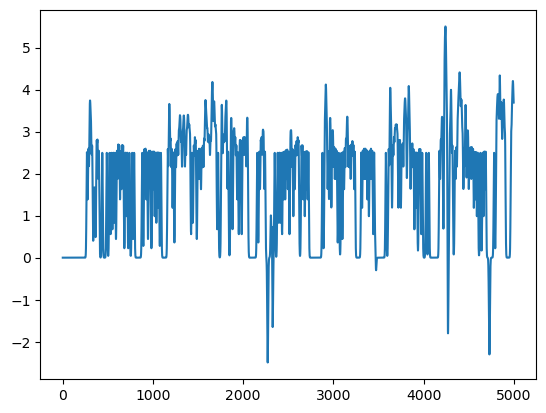

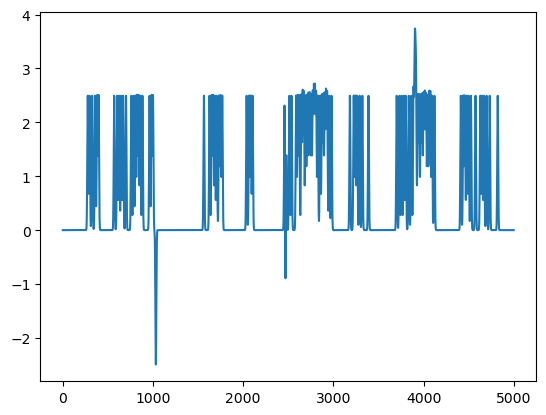

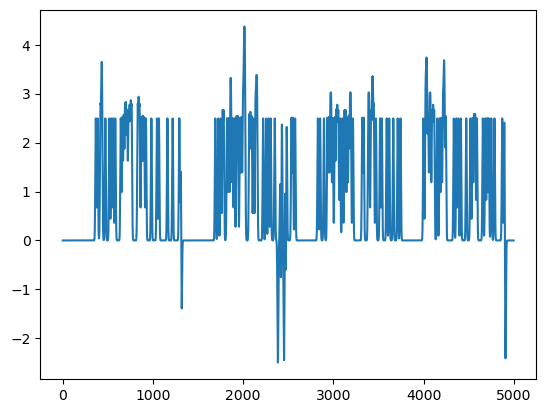

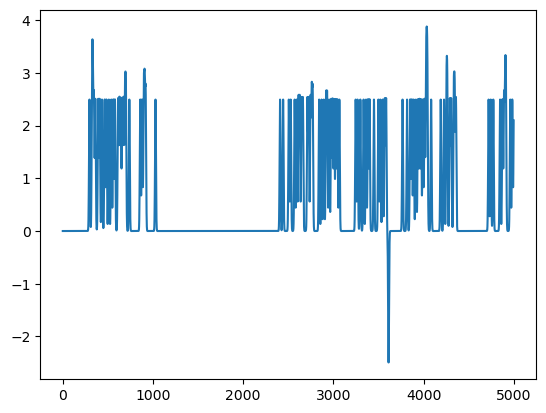

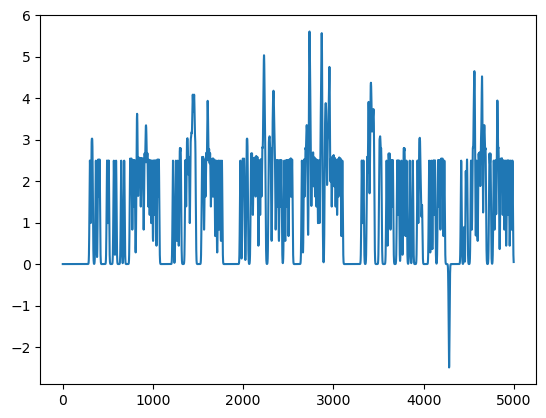

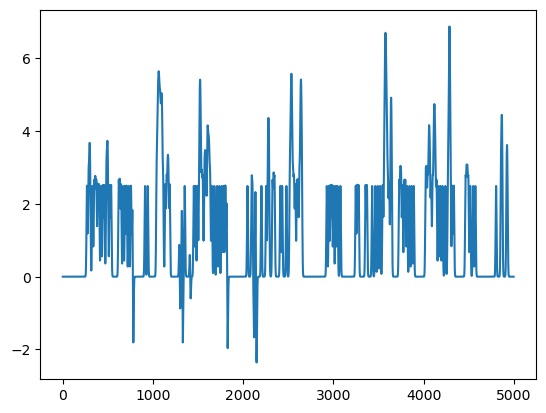

In [44]:
mouse = 'SparseKO_11'
for f in stx.ymaze_sess_deets.SparseKO_sessions[mouse]:
#     print(f)

    
    if isinstance(f,dict):
        f_ = update_sess_dict(mouse,f)
        print(f_)
        _ = run_and_save(f_)

        
        
    